# <h1><center>Workshop 3: Predicción de una falla eléctrica</center></h1>

<a id="indice"></a> 
## Índice

### <a href='#section_objetivos'>0. Objetivos del Workshop</a>


### <a href='#section_dataset'>1. Dataset</a>
- #### <a href='#1.1'>1.1 Análisis generales y balanceo de clases</a>
- #### <a href='#1.2'>1.2 Análisis exploratorio: Correlación, histogramas y boxplots</a>


### <a href='#2.'>2. Entrenamiento de los modelos de clasificación</a>
- #### <a href='#2.1'>2.1 Entrenamiento para la **_target_binaria_**</a>
- #### <a href='#2.2'>2.2 Entrenamiento para la variable multiclass</a>
- #### <a href='#2.3'>2.3 GridSearchCV</a>

### <a href='#3.'>3. Merge de fallas 2 y 5</a>
- #### <a href='#3.1'>3.1 Clasificación con unificación de fallas</a>
- #### <a href='#3.2'>3.2 GridSeachCV unificación de fallas</a>

<a id="section_objetivos"></a> 
## 0. Objetivos del Workshop
<a href='#indice'>Volver a TOC</a>

EL objetivo de este trabajo consiste en poder aplicar un modelo de clasificación a un dataset multiclase de fallas eléctricas de Kaggle, el cuál se puede descargar en el siguiente [`enlace`](https://www.kaggle.com/esathyaprakash/electrical-fault-detection-and-classification?select=classData.csv)

Dicho dataset consta de las siguientes características:
- Inputs: [Ia,Ib,Ic,Va,Vb,Vc] 
- Outputs: [G C B A]

Las variables I hacen referencia a la corriente y las variables V a la tensión de las 3 bobinas de un sistema trifásico.
La clasificación de las fallas vienen dadas por las variables G,C,B,A (binarias) cuya combinación de valores definen el tipo de falla:
- [0 0 0 0] - No falla
- [1 0 0 1] - LG falla(entre fase A y tierra)
- [0 1 1 0] - LL falla(entre fase A and fase B)
- [1 0 1 1] - LLG falla(entre fase A,B y tierra)
- [0 1 1 1] - LLL falla(entre todas las fases)
- [1 1 1 1] - LLLG falla(Falla simétrica: falla en todas las fases y tierra)

<a id="section_dataset"></a> 
## 1. Dataset


<a id="1.1"></a> 
### 1.1 Análisis generales y balanceo de clases
<a href='#indice'>Volver a TOC</a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [2]:
data = pd.read_csv('classData.csv')
data

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983
...,...,...,...,...,...,...,...,...,...,...
7856,0,0,0,0,-66.237921,38.457041,24.912239,0.094421,-0.552019,0.457598
7857,0,0,0,0,-65.849493,37.465454,25.515675,0.103778,-0.555186,0.451407
7858,0,0,0,0,-65.446698,36.472055,26.106554,0.113107,-0.558211,0.445104
7859,0,0,0,0,-65.029633,35.477088,26.684731,0.122404,-0.561094,0.438690


In [3]:
data_null = data.isnull().sum()
data_null

G     0
C     0
B     0
A     0
Ia    0
Ib    0
Ic    0
Va    0
Vb    0
Vc    0
dtype: int64

Como puede observarse, el dataset no posee valores nulos. Ahora lo que se hará es transformar las variables del output (G,C,B,A) en una única llamada **_target_** la cual clasificará la falla en rango numérico del 0 al 5.

In [4]:
def clasifier_fault(data):
    target = []
    for i in range(0,len(data)):
        c = data.iloc[i:int(i+1)].to_numpy().flatten()
        if c[0] == 0 and c[1] == 0 and c[2]==0 and c[3]==0:
            target.append(0)
        elif c[0] == 0 and c[1] == 1 and c[2]==1 and c[3]==0: 
             target.append(1)
        elif c[0] == 0 and c[1] == 1 and c[2]==1 and c[3]==1: 
             target.append(2)
        elif c[0] == 1 and c[1] == 0 and c[2]==0 and c[3]==1: 
             target.append(3)
        elif c[0] == 1 and c[1] == 0 and c[2]==1 and c[3]==1: 
             target.append(4)
        elif c[0] == 1 and c[1] == 1 and c[2]==1 and c[3]==1: 
             target.append(5)
    return target

In [5]:
df = data.loc[:,['G','C','B','A']]
target = clasifier_fault(df)
data['target'] = target
data

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc,target
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815,3
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099,3
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428,3
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570,3
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983,3
...,...,...,...,...,...,...,...,...,...,...,...
7856,0,0,0,0,-66.237921,38.457041,24.912239,0.094421,-0.552019,0.457598,0
7857,0,0,0,0,-65.849493,37.465454,25.515675,0.103778,-0.555186,0.451407,0
7858,0,0,0,0,-65.446698,36.472055,26.106554,0.113107,-0.558211,0.445104,0
7859,0,0,0,0,-65.029633,35.477088,26.684731,0.122404,-0.561094,0.438690,0


Para que sea más simple identificar el tipo de falla, se crea una nueva columna llamada **_falla_** la cual tendrá el tipo de falla en función al valor numérico que se le asignó a la **_target_**

In [6]:
def falla(data):
    target = []
    if data == 0:
        target.append('No hay falla')
    elif data == 1:
        target.append('Falla entre fase A y fase B')
    elif data == 2:
        target.append('Falla en todas las fases')
    elif data == 3:
        target.append('Falla entre fase A y tierra')
    elif data == 4:
        target.append('Falla entre fase A,B y tierra')
    elif data == 5:
        target.append('Falla entre todas las fases y tierra')
    return target

In [7]:
data['falla'] = data.target.apply(lambda x: falla(x))
data['falla'] = data.falla.apply(lambda x: x[0])
data

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc,target,falla
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815,3,Falla entre fase A y tierra
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099,3,Falla entre fase A y tierra
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428,3,Falla entre fase A y tierra
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570,3,Falla entre fase A y tierra
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983,3,Falla entre fase A y tierra
...,...,...,...,...,...,...,...,...,...,...,...,...
7856,0,0,0,0,-66.237921,38.457041,24.912239,0.094421,-0.552019,0.457598,0,No hay falla
7857,0,0,0,0,-65.849493,37.465454,25.515675,0.103778,-0.555186,0.451407,0,No hay falla
7858,0,0,0,0,-65.446698,36.472055,26.106554,0.113107,-0.558211,0.445104,0,No hay falla
7859,0,0,0,0,-65.029633,35.477088,26.684731,0.122404,-0.561094,0.438690,0,No hay falla


A continuación, se analiza el balanceo de las clases del dataset

In [8]:
data_bal = data.loc[:,['Ia','target']].groupby(['target']).count()
data_bal = data_bal.apply(lambda x: x*100/data.shape[0])
data_bal

,Ia
target,
0,30.085231
1,12.771912
2,13.942247
3,14.362040
4,14.425646
5,14.412925


In [9]:
data_bal = data.loc[:,['Ia','falla']].groupby(['falla']).count()
data_bal = data_bal.apply(lambda x: x*100/data.shape[0])
data_bal

,Ia
falla,
Falla en todas las fases,13.942247
Falla entre fase A y fase B,12.771912
Falla entre fase A y tierra,14.362040
"Falla entre fase A,B y tierra",14.425646
Falla entre todas las fases y tierra,14.412925
No hay falla,30.085231


Como puede observarse, el dataset se encuentra desbalanceado entre falla y no falla, aproximadamente en un 30% para no falla y 70% para las fallas. Sin embargo, las fallas sí se encuentran muy bien balanceadas en cuanto a porcentaje de los datos.

Para chequear esto mismo, se crea una nueva variable **_target_binaria_** con el fin de observar dicho desbanlaceo de clases entre falla y no falla.

In [10]:
data['target_binaria'] = data.target.apply(lambda x: x if x == 0 else 1)
data

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc,target,falla,target_binaria
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815,3,Falla entre fase A y tierra,1
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099,3,Falla entre fase A y tierra,1
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428,3,Falla entre fase A y tierra,1
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570,3,Falla entre fase A y tierra,1
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983,3,Falla entre fase A y tierra,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7856,0,0,0,0,-66.237921,38.457041,24.912239,0.094421,-0.552019,0.457598,0,No hay falla,0
7857,0,0,0,0,-65.849493,37.465454,25.515675,0.103778,-0.555186,0.451407,0,No hay falla,0
7858,0,0,0,0,-65.446698,36.472055,26.106554,0.113107,-0.558211,0.445104,0,No hay falla,0
7859,0,0,0,0,-65.029633,35.477088,26.684731,0.122404,-0.561094,0.438690,0,No hay falla,0


In [11]:
data_bal = data.loc[:,['Ia','target_binaria']].groupby(['target_binaria']).count()
data_bal = data_bal.apply(lambda x: x*100/data.shape[0])
data_bal

,Ia
target_binaria,
0,30.085231
1,69.914769


<a id="1.2"></a> 
### 1.2 Análisis exploratorio: Correlación, histogramas y boxplots
<a href='#indice'>Volver a TOC</a>

A continuación, se presenta la correlación que existe entre las features, y las targets creadas

<AxesSubplot:>

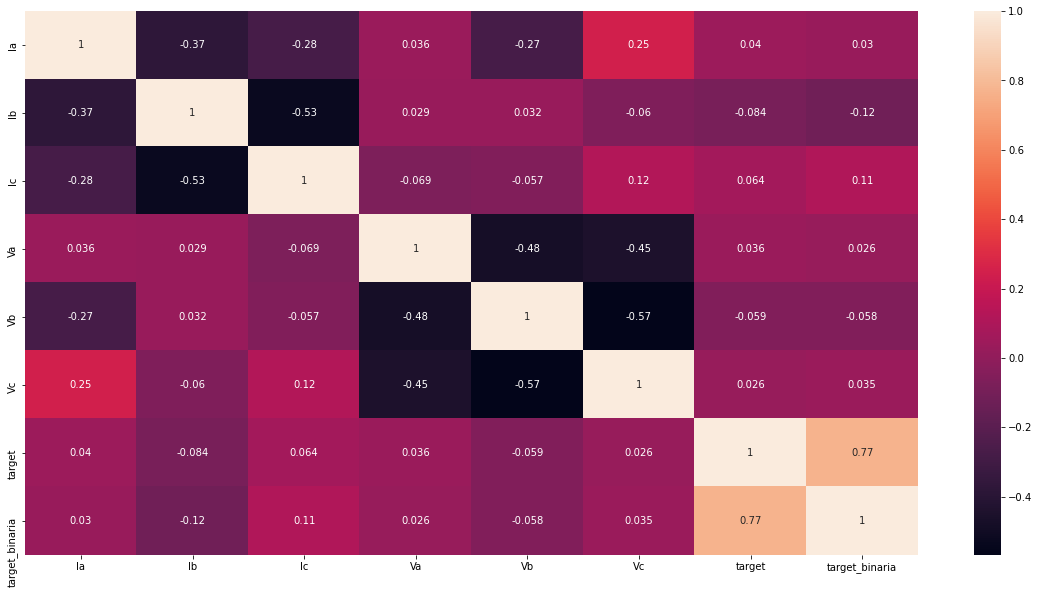

In [12]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.heatmap(data.loc[:,['Ia','Ib','Ic','Va','Vb','Vc','target','target_binaria']].corr(),annot=True,ax=ax)

Luego, se procede a realizar un histograma para cada feature con respecto a la **_target_binaria_** 

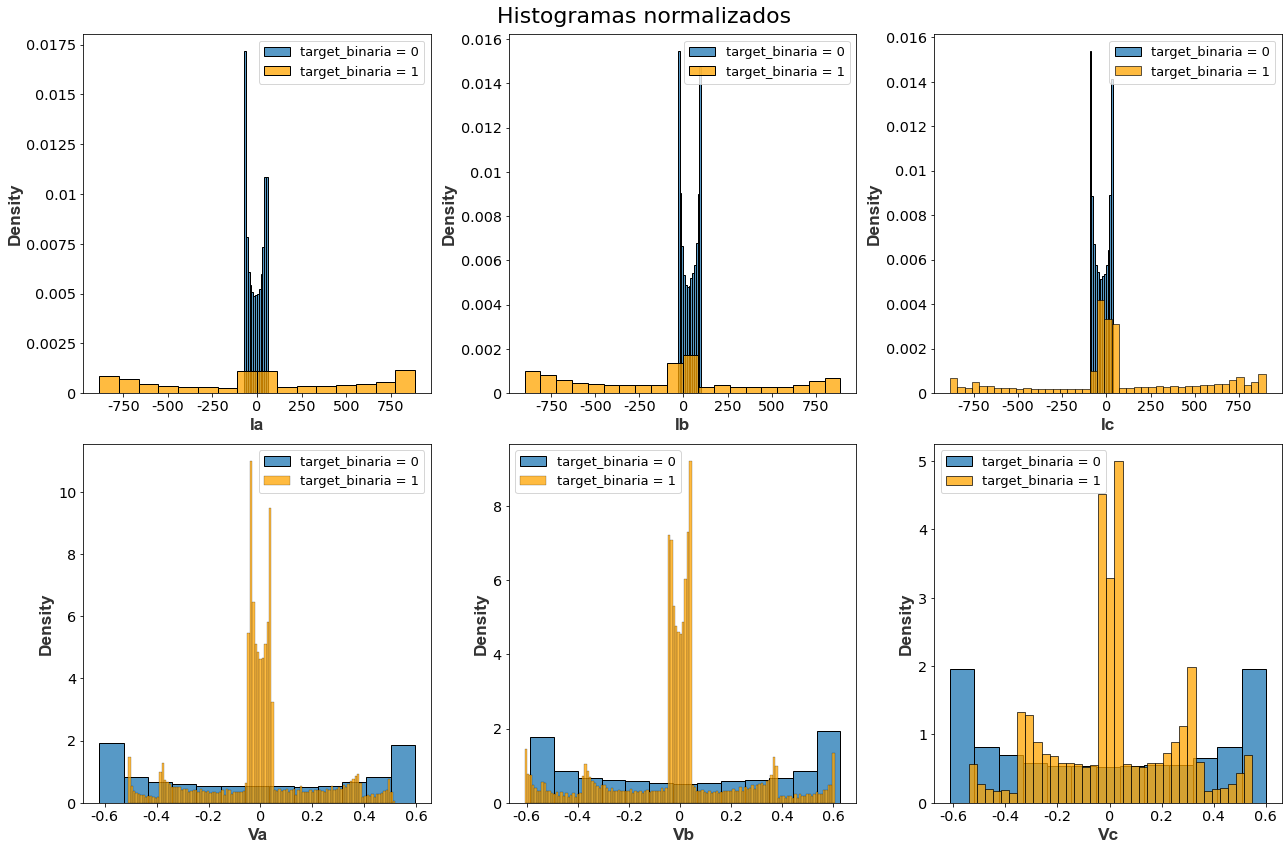

In [13]:
dataplot = data[["Ia","Ib","Ic","Va","Vb","Vc","target_binaria"]]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18,12))
fig.suptitle('Histogramas normalizados',size=22)
label_format = '{0:.3g}'
for c, ax in zip(dataplot.columns[:-1], axes.flatten()):
    sns.histplot(data = dataplot.loc[dataplot['target_binaria']==0, c].dropna(), stat = 'density', ax = ax, kde = False)
    sns.histplot(data = dataplot.loc[dataplot['target_binaria']==1, c].dropna(), stat = 'density', kde=False, ax=ax, color = 'orange')
    ax.legend(['target_binaria = 0', 'target_binaria = 1'],prop={'size': 13})
    x_label = ax.get_xlabel()
    y_label = ax.get_ylabel()
    plt.draw()
    x_ticks = ax.get_xticklabels()
    y_ticks = ax.get_yticklabels()
    ticks_loc = ax.get_yticks().tolist()
    ticks_loc_x = ax.get_xticks().tolist()
    ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc_x))
    ax.set_yticklabels([label_format.format(x) for x in ticks_loc],size='x-large')
    ax.set_xticklabels([label_format.format(x) for x in ticks_loc_x],size='x-large')
    ax.set_xlabel(x_label,weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    ax.set_ylabel(y_label,weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
fig.tight_layout()

Para el caso de la target multiclass, se procede a realizar boxplots para cada features, respecto al tipo de falla correspondiente

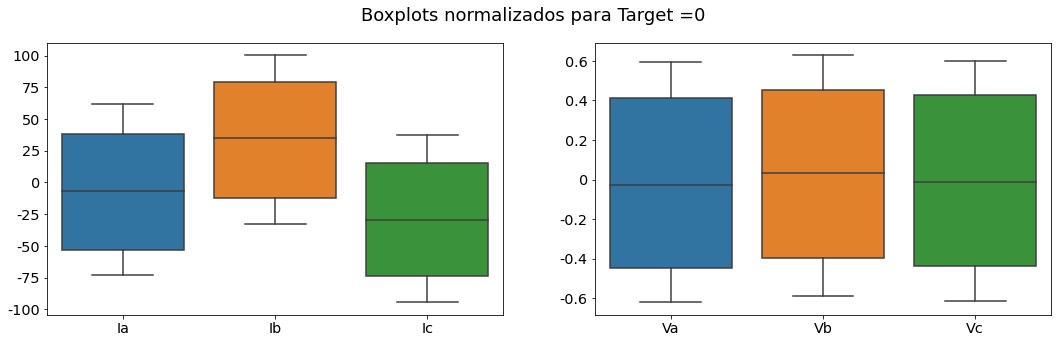

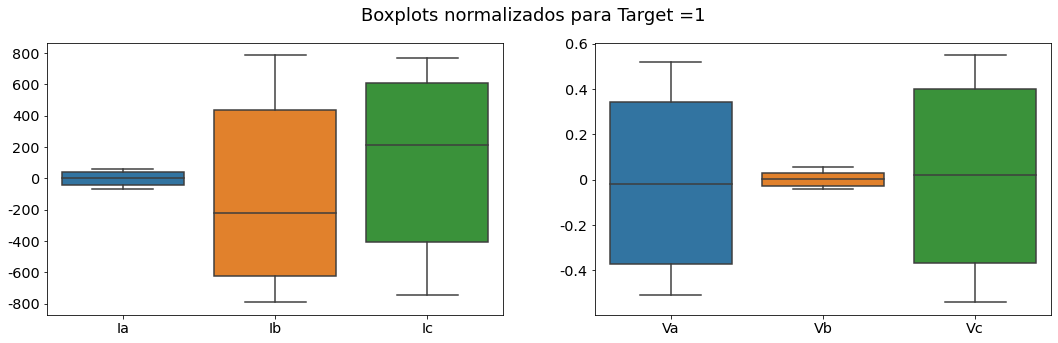

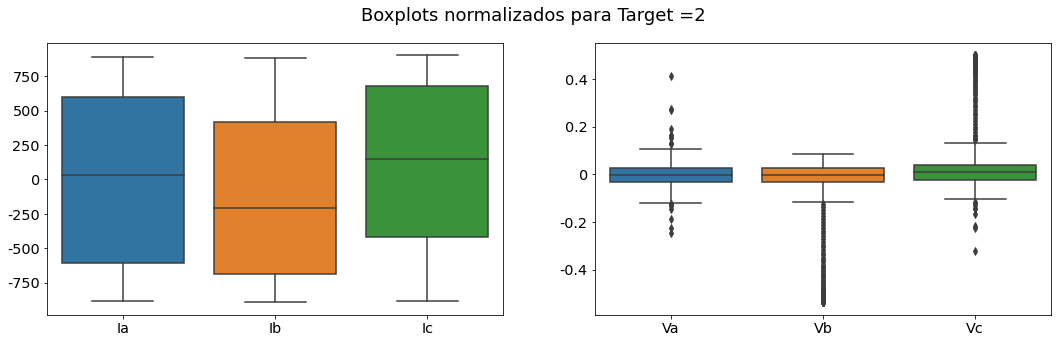

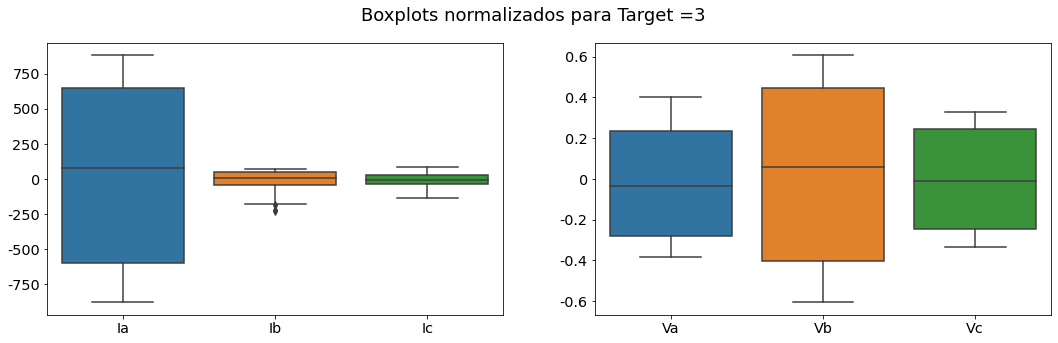

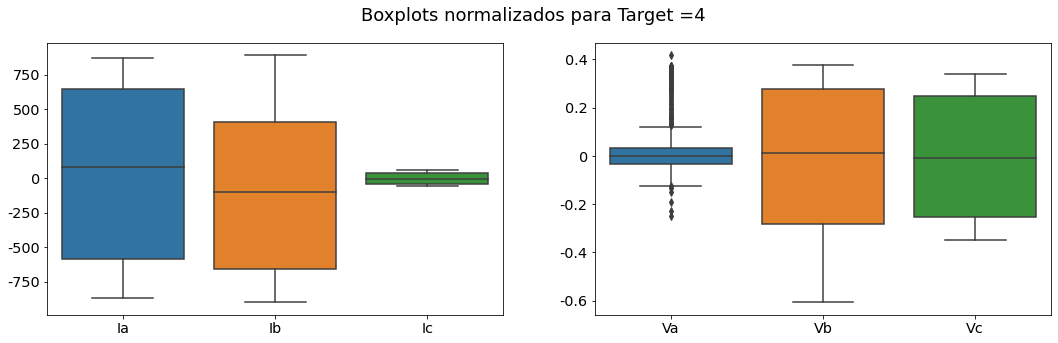

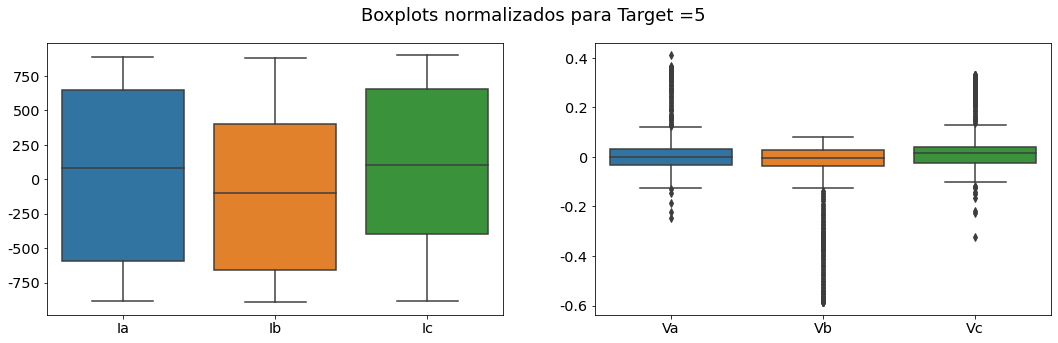

In [14]:
dataplot_corriente = data[["Ia","Ib","Ic","target"]]
dataplot_voltaje = data[["Va","Vb","Vc","target"]]
label_format = '{0:.3g}'
for y in data.target.value_counts().index.sort_values():
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,5))
    fig.suptitle('Boxplots normalizados para Target =%i'%y,size=18)
    for i, ax in zip(range(1,3), axes.flatten()):
        if i == 1:
            sns.boxplot(x="variable", y="value", data=pd.melt(dataplot_corriente.loc[dataplot_corriente.target == y,["Ia","Ib","Ic"]]),ax = ax)
            plt.draw()
            x_ticks = ax.get_xticklabels()
            y_ticks = ax.get_yticklabels()
            ticks_loc = ax.get_yticks().tolist()
            ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
            ax.set_yticklabels([label_format.format(x) for x in ticks_loc],size='x-large')
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_xticklabels(x_ticks,size='x-large')
        else:
            sns.boxplot(x="variable", y="value", data=pd.melt(dataplot_voltaje.loc[dataplot_voltaje.target == y,["Va","Vb","Vc"]]),ax = ax)
            plt.draw()
            x_ticks = ax.get_xticklabels()
            y_ticks = ax.get_yticklabels()
            ticks_loc = ax.get_yticks().tolist()
            ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
            ax.set_yticklabels([label_format.format(x) for x in ticks_loc],size='x-large')
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_xticklabels(x_ticks,size='x-large')

<a id="2."></a> 
## 2. Entrenamiento de los modelos de clasificación

In [15]:
from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_curve,auc
from sklearn.linear_model import LogisticRegression

<a id="2.1"></a> 
## 2.1 Entrenamiento para la **_target_binaria_**
<a href='#indice'>Volver a TOC</a>

En esta primer instancia, se propone entrenar el modelo desbalanceado para la **_target_binaria_** con el algoritmo KNN, sin utilizar GridSearch, ya que el mismo se lo hará para el caso multivariable.

In [16]:
X = data.loc[:,['Ia','Ib','Ic','Va','Vb','Vc']]
y = data.target_binaria

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

In [18]:
scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

In [19]:
knn = KNeighborsClassifier()
knn.fit(X_train_scaler, y_train)

KNeighborsClassifier()

In [20]:
y_pred_train = knn.predict(X_train_scaler)

1.0


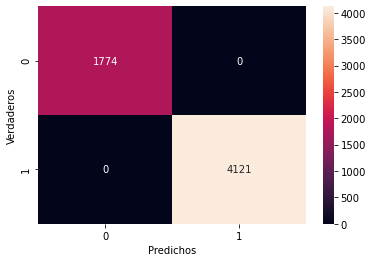

In [21]:
print(accuracy_score(y_train, y_pred_train))
cm = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm, annot=True,fmt='d')
plt.ylabel('Verdaderos')
plt.xlabel('Predichos');

0.9994913530010173


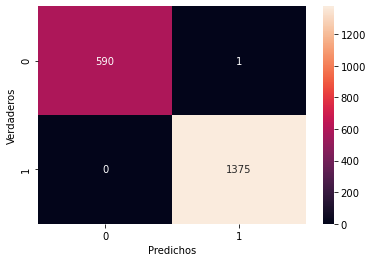

In [22]:
y_pred_test = knn.predict(X_test_scaler)
print(accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True,fmt='d')
plt.ylabel('Verdaderos')
plt.xlabel('Predichos');

Se puede observar que el accuracy del algoritmo es muy bueno, incluso sin haber seteado ningún hiperparámetro y utilizando los que ya vienen por default. Para mayor información se presenta los datos de otras métricas de la matriz de confusión, como también así curva de ROC y el Area bajo la curva de ROC.

In [23]:
print(classification_report(y_test, y_pred_test, target_names = ['No Falla','Falla']))

              precision    recall  f1-score   support

    No Falla       1.00      1.00      1.00       591
       Falla       1.00      1.00      1.00      1375

    accuracy                           1.00      1966
   macro avg       1.00      1.00      1.00      1966
weighted avg       1.00      1.00      1.00      1966



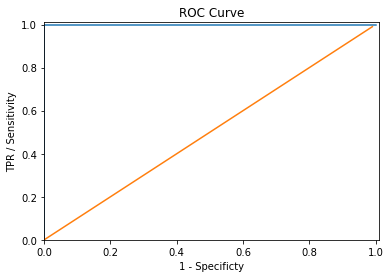

In [24]:
y_pred_knn_roc = knn.predict_proba(X_test_scaler)
fpr,tpr,_ = roc_curve(y_test, y_pred_knn_roc[:,1])
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')
plt.plot(df['fpr'],df['tpr'])
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.show() 

Ahora, se propone realizar lo mismo, epro esta vez se utilizará el modelo de la regresión logística.

In [25]:
logistic_regression = LogisticRegression() 
logistic_regression.fit(X_train, y_train)

LogisticRegression()

0.6990670059372349


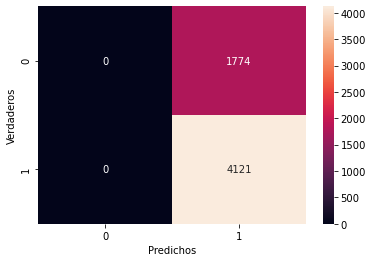

In [26]:
y_pred_train_lr = logistic_regression.predict(X_train_scaler)
print(accuracy_score(y_train, y_pred_train_lr))
cm_train_lr = confusion_matrix(y_train, y_pred_train_lr)
sns.heatmap(cm_train_lr, annot=True,fmt='d')
plt.ylabel('Verdaderos')
plt.xlabel('Predichos');

0.6993896236012207


<AxesSubplot:>

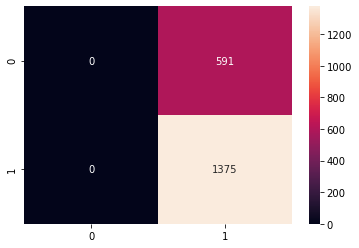

In [27]:
y_pred_test_lr = logistic_regression.predict(X_test)
print(accuracy_score(y_test, y_pred_test_lr))
cm_test_lr = confusion_matrix(y_test, y_pred_test_lr)
sns.heatmap(cm_test_lr, annot=True,fmt='d')

Como se puede observar, el algoritmo no performa bien, ya que se encuentra muy sesgado, decidiendo todas las clases negativas como falsas positivas. Esto puede deberse al debalanceo del dataset. Sin embargo, modificar el umbral tampoco ayudó a mejorar la performance del mismo

0.5988125530110263


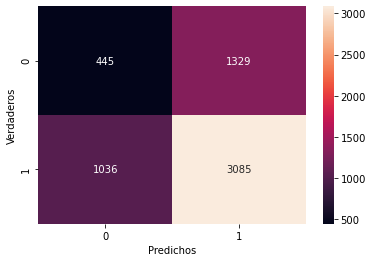

In [28]:
y_pred_train_lr_proba = logistic_regression.predict_proba(X_train)
umbral = 0.65
preds = np.where(y_pred_train_lr_proba[:,1] > umbral, 1, 0)
print(accuracy_score(y_train, preds))
cm_train_lr = confusion_matrix(y_train, preds)
sns.heatmap(cm_train_lr, annot=True,fmt='d')
plt.ylabel('Verdaderos')
plt.xlabel('Predichos');

A medida que se vaya modificando el umbral, se observará que el accuracy nunca será mejor que el 70 %, y el al intentar mejorar los TN, se pierde precisión y empeora el accuracy. Es por este motivo, que se elige KNN como algoritmo de predicción para el caso multiclass y para este también.

<a id="2.2"></a> 
## 2.2 Entrenamiento para la variable multiclass
<a href='#indice'>Volver a TOC</a>

In [29]:
y = data.target

In [30]:
X_train_mc, X_test_mc, y_train_mc, y_test_mc = train_test_split(X, y,stratify=y, random_state=0)

In [31]:
scaler = StandardScaler()
X_train_scaler_mc = scaler.fit_transform(X_train_mc)
X_test_scaler_mc = scaler.transform(X_test_mc)

In [32]:
knn.fit(X_train_scaler_mc, y_train_mc)

KNeighborsClassifier()

In [33]:
y_pred_train_mc = knn.predict(X_train_scaler_mc)

0.8729431721798134


<AxesSubplot:>

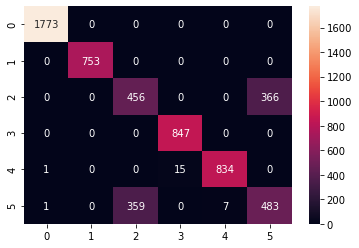

In [34]:
print(accuracy_score(y_train_mc, y_pred_train_mc))
cm = confusion_matrix(y_train_mc, y_pred_train_mc)
sns.heatmap(cm, annot=True,fmt='d')

0.8041709053916581


<AxesSubplot:>

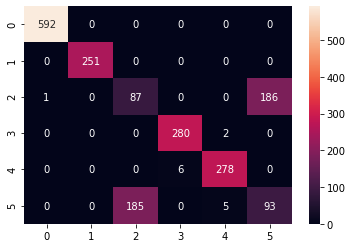

In [35]:
y_pred_test_mc = knn.predict(X_test_scaler_mc)
print(accuracy_score(y_test_mc, y_pred_test_mc))
cm = confusion_matrix(y_test_mc, y_pred_test_mc)
sns.heatmap(cm, annot=True,fmt='d')

Como se puede observar, la performance no es tan buena como el caso binario, es por este motivo, que se prodece a utilizar GridSearchCV para encontrar una mejor selección de hiperparámetros y mejorar así la performance del algoritmo.

<a id="2.3"></a> 
## 2.3 GridSearchCV
<a href='#indice'>Volver a TOC</a>

In [36]:
k_range = list(range(1, 31))
weight_options = ['uniform', 'distance']
param_grid = dict(n_neighbors=k_range, weights=weight_options)

In [37]:
folds=StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

In [38]:
grid = GridSearchCV(knn, param_grid, cv=folds, scoring='accuracy')

In [39]:
grid.fit(X_train_scaler_mc, y_train_mc)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [40]:
pd.DataFrame(grid.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.012841,0.003585,0.026315,0.006490,1,uniform,"{'n_neighbors': 1, 'weights': 'uniform'}",0.869492,0.883051,0.876271,0.879661,0.871186,0.874363,0.867572,0.862479,0.872666,0.891341,0.874808,0.007858,1
1,0.011281,0.005064,0.004285,0.003800,1,distance,"{'n_neighbors': 1, 'weights': 'distance'}",0.869492,0.883051,0.876271,0.879661,0.871186,0.874363,0.867572,0.862479,0.872666,0.891341,0.874808,0.007858,1
2,0.009996,0.004472,0.022241,0.003923,2,uniform,"{'n_neighbors': 2, 'weights': 'uniform'}",0.835593,0.828814,0.842373,0.832203,0.840678,0.840407,0.845501,0.833616,0.840407,0.842105,0.838170,0.005037,32
3,0.009007,0.003002,0.003996,0.004894,2,distance,"{'n_neighbors': 2, 'weights': 'distance'}",0.869492,0.883051,0.876271,0.879661,0.871186,0.874363,0.867572,0.862479,0.872666,0.891341,0.874808,0.007858,1
4,0.008996,0.005386,0.021999,0.003993,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",0.808475,0.786441,0.793220,0.784746,0.803390,0.809847,0.796265,0.796265,0.797963,0.814941,0.799155,0.009439,60


In [41]:
grid.best_estimator_

KNeighborsClassifier(n_neighbors=1)

In [42]:
grid.best_score_

0.874808206958073

In [43]:
grid.best_params_

{'n_neighbors': 1, 'weights': 'uniform'}

In [44]:
y_pred_grid = grid.predict(X_test_scaler_mc)

In [45]:
target_names = ['No Falla','Falla entre fase A y fase B','Falla en todas las fases',
                'Falla entre fase A y tierra','Falla entre fase A,B y tierra',
                'Falla entre todas las fases y tierra']
print(classification_report(y_test_mc, y_pred_grid,target_names=target_names))

                                      precision    recall  f1-score   support

                            No Falla       1.00      1.00      1.00       592
         Falla entre fase A y fase B       1.00      1.00      1.00       251
            Falla en todas las fases       0.59      0.58      0.58       274
         Falla entre fase A y tierra       0.98      1.00      0.99       282
       Falla entre fase A,B y tierra       1.00      0.98      0.99       284
Falla entre todas las fases y tierra       0.59      0.61      0.60       283

                            accuracy                           0.88      1966
                           macro avg       0.86      0.86      0.86      1966
                        weighted avg       0.88      0.88      0.88      1966



<AxesSubplot:>

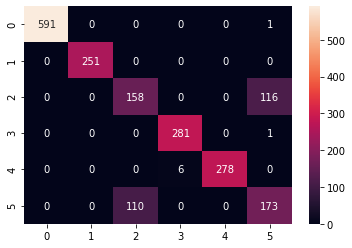

In [46]:
confusion = confusion_matrix(y_test_mc, y_pred_grid)
sns.heatmap(confusion, annot=True,fmt='d')

Se puede observar que el algoritmo posee muchos falsos positivos tanto para la falla 2 con la falla 5 y viceserva. De manera que se intuye que existe una alta correlación entre estas fallas, así que se propone unificarlas en una única falla llamada 'Falla total' para observar como performa el mismo.

<a id="3."></a> 
## 3. Merge de fallas 2 y 5
<a href='#indice'>Volver a TOC</a>

In [47]:
def clasifier_fault_unification(data):
    target = []
    for i in range(0,len(data)):
        c = data.iloc[i:int(i+1)].to_numpy().flatten()
        if c[0] == 0 and c[1] == 0 and c[2]==0 and c[3]==0:
            target.append(0)
        elif c[0] == 0 and c[1] == 1 and c[2]==1 and c[3]==0: 
             target.append(1)
        elif c[0] == 0 and c[1] == 1 and c[2]==1 and c[3]==1: 
             target.append(2)
        elif c[0] == 1 and c[1] == 0 and c[2]==0 and c[3]==1: 
             target.append(3)
        elif c[0] == 1 and c[1] == 0 and c[2]==1 and c[3]==1: 
             target.append(4)
        elif c[0] == 1 and c[1] == 1 and c[2]==1 and c[3]==1: 
             target.append(2)
    return target

In [48]:
def falla_unificacion(data):
    target = []
    if data == 0:
        target.append('No hay falla')
    elif data == 1:
        target.append('Falla entre fase A y fase B')
    elif data == 2:
        target.append('Falla Total')
    elif data == 3:
        target.append('Falla entre fase A y tierra')
    elif data == 4:
        target.append('Falla entre fase A,B y tierra')
    return target

In [49]:
df_unif = data.loc[:,['G','C','B','A']]
target_unif = clasifier_fault_unification(df_unif)
data['target_unif'] = target_unif
data['falla_unif'] = data.target_unif.apply(lambda x: falla_unificacion(x))
data['falla_unif'] = data.falla_unif.apply(lambda x: x[0])
data.sample(5)

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc,target,falla,target_binaria,target_unif,falla_unif
65,1,0,0,1,-701.537145,-24.870535,-21.323767,-0.099878,0.434583,-0.334706,3,Falla entre fase A y tierra,1,3,Falla entre fase A y tierra
1853,1,0,1,1,173.791633,659.410304,57.750302,0.040679,-0.288961,0.248282,4,"Falla entre fase A,B y tierra",1,4,"Falla entre fase A,B y tierra"
5228,1,1,1,1,-798.120677,70.588785,727.529628,-0.033874,0.039018,-0.005144,5,Falla entre todas las fases y tierra,1,2,Falla Total
236,1,0,0,1,879.342097,52.810696,1.317679,-0.062236,-0.204515,0.266751,3,Falla entre fase A y tierra,1,3,Falla entre fase A y tierra
6614,0,0,0,0,-69.747221,79.063884,-12.548976,-0.295055,-0.303940,0.598995,0,No hay falla,0,0,No hay falla


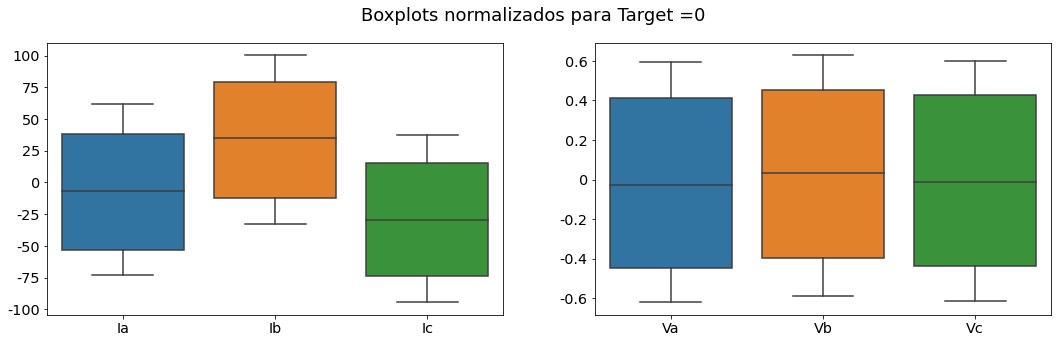

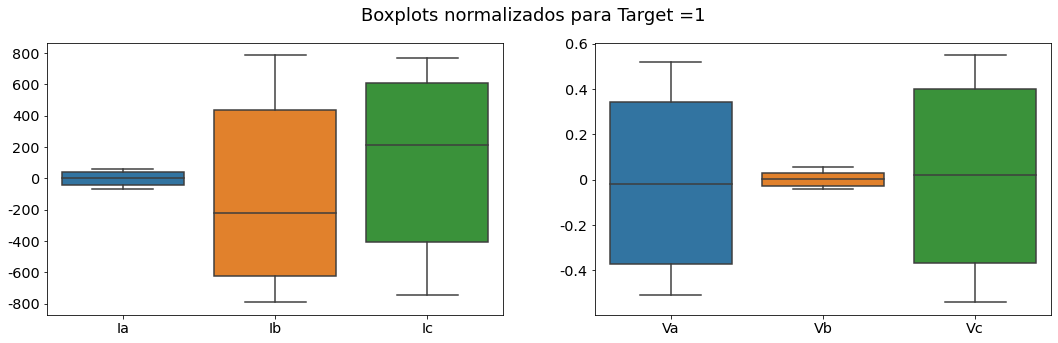

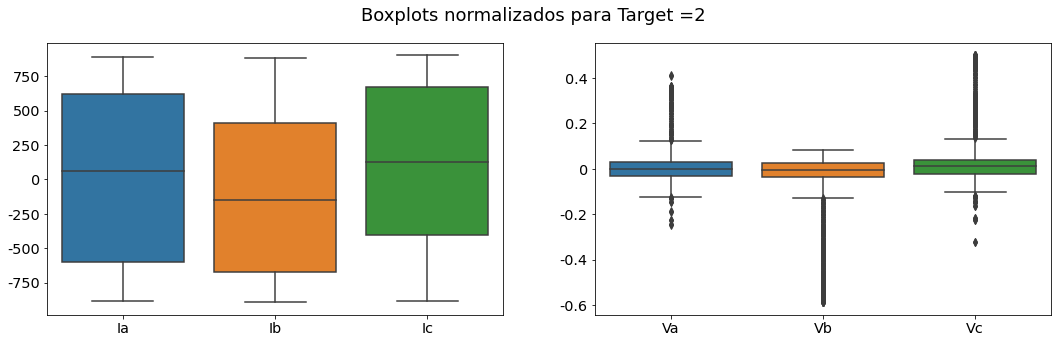

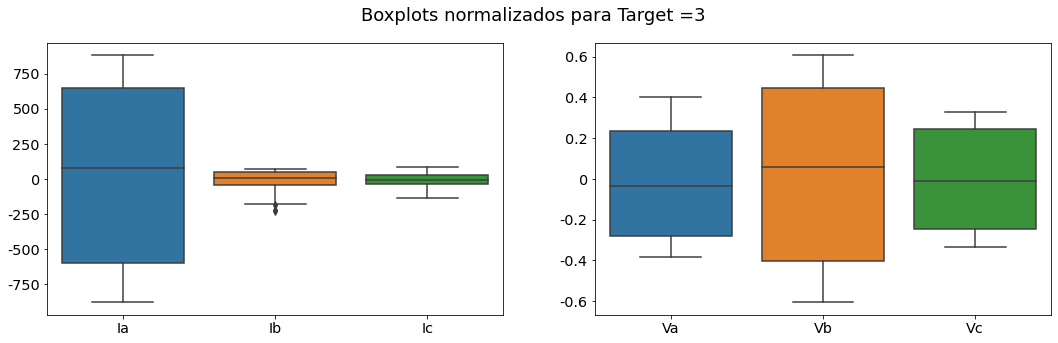

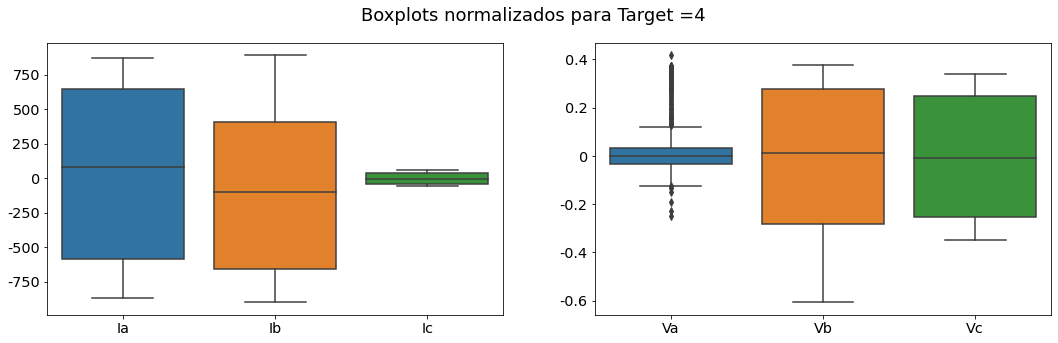

In [50]:
dataplot_corriente1 = data[["Ia","Ib","Ic","target_unif"]]
dataplot_voltaje1 = data[["Va","Vb","Vc","target_unif"]]
for y in data.target_unif.value_counts().index.sort_values():
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,5))
    fig.suptitle('Boxplots normalizados para Target =%i'%y,size=18)
    for i, ax in zip(range(1,3), axes.flatten()):
        if i == 1:
            sns.boxplot(x="variable", y="value", data=pd.melt(dataplot_corriente1.loc[dataplot_corriente1.target_unif == y,
                                                                                      ["Ia","Ib","Ic"]]),ax = ax)
            plt.draw()
            x_ticks = ax.get_xticklabels()
            y_ticks = ax.get_yticklabels()
            ticks_loc = ax.get_yticks().tolist()
            ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
            ax.set_yticklabels([label_format.format(x) for x in ticks_loc],size='x-large')
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_xticklabels(x_ticks,size='x-large')
        else:
            sns.boxplot(x="variable", y="value", data=pd.melt(dataplot_voltaje1.loc[dataplot_voltaje1.target_unif == y,
                                                                                    ["Va","Vb","Vc"]]),ax = ax)
            plt.draw()
            x_ticks = ax.get_xticklabels()
            y_ticks = ax.get_yticklabels()
            ticks_loc = ax.get_yticks().tolist()
            ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
            ax.set_yticklabels([label_format.format(x) for x in ticks_loc],size='x-large')
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_xticklabels(x_ticks,size='x-large')

<a id="3.1"></a> 
## 3.1 Clasificación con unificación de fallas
<a href='#indice'>Volver a TOC</a>

In [51]:
y = data.target_unif

In [52]:
X_train_mc_2, X_test_mc_2, y_train_mc_2, y_test_mc_2 = train_test_split(X, y,stratify=y, random_state=0)

In [53]:
scaler = StandardScaler()
X_train_scaler_mc_2 = scaler.fit_transform(X_train_mc_2)
X_test_scaler_mc_2 = scaler.transform(X_test_mc_2)

In [54]:
knn.fit(X_train_scaler_mc_2, y_train_mc_2)

KNeighborsClassifier()

In [55]:
y_pred_train_mc_2 = knn.predict(X_train_scaler_mc_2)

0.9938931297709923


<AxesSubplot:>

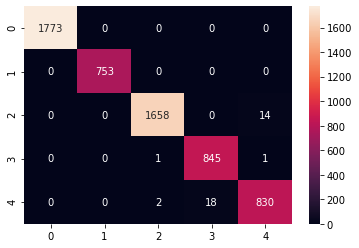

In [56]:
print(accuracy_score(y_train_mc_2, y_pred_train_mc_2))
cm = confusion_matrix(y_train_mc_2, y_pred_train_mc_2)
sns.heatmap(cm, annot=True,fmt='d')

0.9908443540183113


<AxesSubplot:>

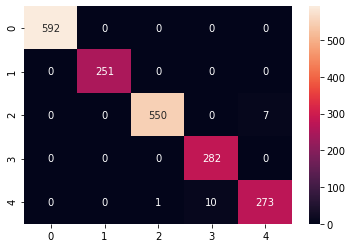

In [57]:
y_pred_test_mc_2 = knn.predict(X_test_scaler_mc_2)
print(accuracy_score(y_test_mc_2, y_pred_test_mc_2))
cm = confusion_matrix(y_test_mc_2, y_pred_test_mc_2)
sns.heatmap(cm, annot=True,fmt='d')

Se puede observar que el rendimiento mejoró notablemente fusionando ambas fallas. Ahora se procede a realizar GridSearchCV para obtener la mejor combinación de hiperparámetros.

<a id="3.2"></a> 
## 3.2 GridSeachCV unificación de fallas
<a href='#indice'>Volver a TOC</a>

In [58]:
folds=StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

In [59]:
grid2 = GridSearchCV(knn, param_grid, cv=folds, scoring='accuracy')

In [60]:
grid2.fit(X_train_scaler_mc_2, y_train_mc_2)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [61]:
pd.DataFrame(grid2.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.010239,0.003233,0.019898,0.000685,1,uniform,"{'n_neighbors': 1, 'weights': 'uniform'}",0.996610,0.991525,0.996610,0.993220,0.994915,0.996604,0.998302,0.996604,0.998302,0.998302,0.996100,0.002149,1
1,0.009147,0.004582,0.003602,0.004345,1,distance,"{'n_neighbors': 1, 'weights': 'distance'}",0.996610,0.991525,0.996610,0.993220,0.994915,0.996604,0.998302,0.996604,0.998302,0.998302,0.996100,0.002149,1
2,0.013370,0.007287,0.030725,0.010942,2,uniform,"{'n_neighbors': 2, 'weights': 'uniform'}",0.993220,0.991525,0.996610,0.991525,0.993220,0.996604,0.996604,0.996604,0.996604,0.998302,0.995082,0.002328,4
3,0.010470,0.003316,0.005292,0.001795,2,distance,"{'n_neighbors': 2, 'weights': 'distance'}",0.996610,0.991525,0.996610,0.993220,0.994915,0.996604,0.998302,0.996604,0.998302,0.998302,0.996100,0.002149,1
4,0.012534,0.004021,0.029745,0.006635,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",0.991525,0.991525,0.994915,0.986441,0.988136,0.994907,0.996604,0.993209,0.994907,0.993209,0.992538,0.003048,7


In [62]:
grid2.best_estimator_

KNeighborsClassifier(n_neighbors=1)

In [63]:
grid2.best_score_

0.9960996805847312

In [64]:
grid2.best_params_

{'n_neighbors': 1, 'weights': 'uniform'}

In [65]:
y_pred_grid2 = grid2.predict(X_test_scaler_mc_2)

In [66]:
target_names = ['No Falla','Falla entre fase A y fase B','Falla Total',
                'Falla entre fase A y tierra','Falla entre fase A,B y tierra']
print(classification_report(y_test_mc_2, y_pred_grid2,target_names=target_names))

                               precision    recall  f1-score   support

                     No Falla       1.00      1.00      1.00       592
  Falla entre fase A y fase B       1.00      1.00      1.00       251
                  Falla Total       1.00      1.00      1.00       557
  Falla entre fase A y tierra       0.97      1.00      0.99       282
Falla entre fase A,B y tierra       1.00      0.97      0.99       284

                     accuracy                           1.00      1966
                    macro avg       0.99      0.99      0.99      1966
                 weighted avg       1.00      1.00      1.00      1966



<AxesSubplot:>

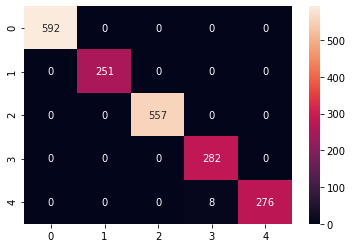

In [67]:
confusion = confusion_matrix(y_test_mc_2, y_pred_grid2)
sns.heatmap(confusion, annot=True,fmt='d')

Se puede observar que el algoritmo performa muy bien para el caso multiclass con unificación de fallas. Sin embargo, es interesante que el mejor K sea igual a 1. Se asume que esto puede deberse a que las clases están muy bien separadas o bien, la cantidad de características son pocas, lo que obliga al algoritmo a complejizarse para obtener mejores valores.